In [113]:
import numpy as np
import pandas as pd
import yfinance as yf

<Axes: xlabel='Date'>

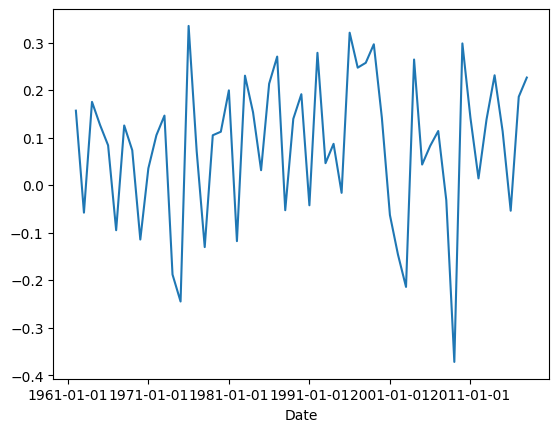

In [114]:
sp500 = pd.read_csv('../data/snp500.csv', index_col='Date')
sp500 = sp500.iloc[::12, :][90:].SP500
sp500.pct_change().plot()

In [115]:
def get_return_rate(df, shift):
    return np.power(df/df.shift(shift), (1/shift))-np.ones(df.shape[0])

In [116]:
sp500_return = pd.DataFrame({f'{freq}Y': get_return_rate(sp500, freq) for freq in [1, 5, 10, 20]}, index=sp500.index)
sp500_return.describe()

,1Y,5Y,10Y,20Y
count,57.000000,53.000000,48.000000,38.000000
mean,0.081760,0.068757,0.065253,0.075655
std,0.155348,0.070817,0.050435,0.028916
min,-0.372204,-0.052849,-0.035988,0.026834
25%,-0.031878,0.007108,0.022573,0.056204
50%,0.112225,0.082745,0.062827,0.069147
75%,0.191205,0.116627,0.106419,0.096476
max,0.334895,0.251013,0.159052,0.136196


In [117]:
pce = pd.read_csv('../data/PCEPI.csv', index_col='DATE')
pce = pce.iloc[::12, :].PCEPI.pct_change()
pce.index.name = 'Date'
pce.describe()

count    65.000000
mean      0.032861
std       0.024495
min      -0.001111
25%       0.016150
50%       0.024023
75%       0.042546
max       0.110913
Name: PCEPI, dtype: float64

In [118]:
df_inf = pd.merge(sp500, sp500_return, left_index=True, right_index=True).join(pce)
data = [df_inf.iloc[0].SP500]
for idx, v in df_inf[1:].iterrows():
    i = len(data)
    data.append(data[i-1]*(1+v['1Y'])*(1-v.PCEPI))
inflation_returns = pd.Series(data, index=df_inf.index)

rate_w_inflation = pd.DataFrame({f'{freq}Y': get_return_rate(inflation_returns, freq) for freq in [1, 5, 10, 20]}, index=inflation_returns.index)
rate_w_inflation.describe()

,1Y,5Y,10Y,20Y
count,57.000000,53.000000,48.000000,38.000000
mean,0.046164,0.031497,0.025983,0.034698
std,0.157052,0.077630,0.056640,0.036404
min,-0.371507,-0.124596,-0.065099,-0.027984
25%,-0.062270,-0.031764,-0.022037,0.004025
50%,0.065398,0.027177,0.030362,0.038974
75%,0.158395,0.079248,0.070360,0.061337
max,0.294556,0.229945,0.130869,0.096634


In [119]:
data = {}
for freq in [10, 20]:
    r = (inflation_returns-inflation_returns.shift(freq))
    r_tax = r*0.2
    total_r = (inflation_returns-r_tax).clip(lower=inflation_returns)
    data[f'{freq}Y'] = get_return_rate(total_r, freq)
rate_w_tax = pd.DataFrame(data, index=inflation_returns.index)
rate_w_tax.describe()

,10Y,20Y
count,38.000000,18.000000
mean,0.038594,0.053366
std,0.048669,0.016065
min,-0.048528,0.031095
25%,0.003565,0.038659
50%,0.037531,0.052798
75%,0.070687,0.062649
max,0.130869,0.084932
